In [1]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from scipy import signal

import matplotlib.pyplot as plt
import scipy.io as sio
import neurokit2 as nk
import seaborn as sns

import pandas as pd
import numpy as np
import time
import numpy as np
import neurokit2 as nk
from scipy.signal import spectrogram

In [2]:
def preprocess_EEG(raw, feature):
    overall = signal.firwin(9, [0.0625, 0.46875], window="hamming")
    theta = signal.firwin(9, [0.0625, 0.125], window="hamming")
    alpha = signal.firwin(9, [0.125, 0.203125], window="hamming")
    beta = signal.firwin(9, [0.203125, 0.46875], window="hamming")
    filt_data = signal.filtfilt(overall, 1, raw)
    filt_theta = signal.filtfilt(theta, 1, filt_data)
    filt_alpha = signal.filtfilt(alpha, 1, filt_data)
    filt_beta = signal.filtfilt(beta, 1, filt_data)
    ftheta, psdtheta = signal.welch(filt_theta, nperseg=256)
    falpha, psdalpha = signal.welch(filt_alpha, nperseg=256)
    fbeta, psdbeta = signal.welch(filt_beta, nperseg=256)
    feature.append(max(psdtheta))
    feature.append(max(psdalpha))
    feature.append(max(psdbeta))
    return feature

In [3]:
def participant_affective(raw):
    a = np.zeros((23, 18, 9), dtype=object)
    for participant in range(0, 23):
        for video in range(0, 18):
            a[participant, video, 0] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Age"][0][0][0])
            a[participant, video, 1] = (raw["DREAMER"][0, 0]["Data"]
                                        [0, participant]["Gender"][0][0][0])
            a[participant, video, 2] = int(participant+1)
            a[participant, video, 3] = int(video+1)
            a[participant, video, 4] = ["Searching for Bobby Fischer",
                                        "D.O.A.", "The Hangover", "The Ring",
                                        "300", "National Lampoon\'s VanWilder",
                                        "Wall-E", "Crash", "My Girl",
                                        "The Fly", "Pride and Prejudice",
                                        "Modern Times", "Remember the Titans",
                                        "Gentlemans Agreement", "Psycho",
                                        "The Bourne Identitiy",
                                        "The Shawshank Redemption",
                                        "The Departed"][video]
            a[participant, video, 5] = ["calmness", "surprise", "amusement",
                                        "fear", "excitement", "disgust",
                                        "happiness", "anger", "sadness",
                                        "disgust", "calmness", "amusement",
                                        "happiness", "anger", "fear",
                                        "excitement", "sadness",
                                        "surprise"][video]
            a[participant, video, 6] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreValence"]
                                           [0, 0][video, 0])
            a[participant, video, 7] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreArousal"]
                                           [0, 0][video, 0])
            a[participant, video, 8] = int(raw["DREAMER"][0, 0]["Data"]
                                           [0, participant]["ScoreDominance"]
                                           [0, 0][video, 0])
    b = pd.DataFrame(a.reshape((23*18, a.shape[2])),
                     columns=["age", "gender", "participant",
                              "video", "video_name", "target_emotion",
                              "valence", "arousal", "dominance"])
    return b

## Standard Features Extraction

In [4]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.signal as signal
import scipy.stats as stats
import neurokit2 as nk
import gc
from tqdm.notebook import tqdm # Use notebook version for better display

# %% Helper Function: Calculate Band Power from PSD
def bandpower(psd, freqs, band, total_power):
    """Calculates power in a frequency band, normalized by total power."""
    band = np.asarray(band)
    low, high = band
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = np.trapz(psd[idx_band], freqs[idx_band])
    # Normalize by total power (optional, but good practice)
    if total_power > 0:
        bp /= total_power
    return bp

# %% Helper Function: Calculate Hjorth Parameters
def calculate_hjorth(signal_data):
    """Calculates Hjorth parameters: Activity, Mobility, Complexity."""
    if len(signal_data) < 2:
        return 0.0, 0.0, 0.0

    # Activity (Variance)
    activity = np.var(signal_data)

    # Mobility (Standard deviation of the first derivative / Standard deviation of signal)
    diff_signal = np.diff(signal_data)
    if activity < 1e-8 or len(diff_signal) < 1:
        mobility = 0.0
    else:
        mobility = np.sqrt(np.var(diff_signal) / activity)

    # Complexity (Mobility of the first derivative / Mobility of signal)
    diff_diff_signal = np.diff(diff_signal)
    if mobility < 1e-8 or len(diff_diff_signal) < 1:
        complexity = 0.0
    else:
        var_diff_diff = np.var(diff_diff_signal)
        var_diff = np.var(diff_signal)
        if var_diff < 1e-8:
             complexity = 0.0
        else:
             mobility_of_diff = np.sqrt(var_diff_diff / var_diff)
             complexity = mobility_of_diff / mobility

    return activity, mobility, complexity

# %% New EEG Feature Extraction Function
def extract_fixed_EEG_features(raw, sampling_rate=128): # DREAMER EEG is 128Hz!
    """
    Extracts fixed statistical and frequency-domain features from EEG data.

    Parameters:
      - raw: the raw data dictionary from DREAMER.mat.
      - sampling_rate: sampling frequency of EEG (should be 128 for DREAMER).

    Returns:
      A pandas DataFrame where each row corresponds to one (participant, video) sample
      and columns are calculated features.
    """
    all_features_list = []
    n_participants = 23
    n_videos = 18
    n_channels = 14 # DREAMER EEG channels

    bands = {
        'Theta': [4, 8],
        'Alpha': [8, 13],
        'Beta': [13, 30],
        'Gamma': [30, 50] # Adjust upper limit as needed
    }

    print("Extracting fixed EEG features...")
    for participant in tqdm(range(n_participants), desc="Participants (EEG)"):
        for video in range(n_videos):
            sample_features = {}
            sample_features['participant'] = participant + 1
            sample_features['video'] = video + 1

            for i in range(n_channels):
                channel_prefix = f'EEG_Ch{i+1}'
                try:
                    basl = raw["DREAMER"][0, 0]["Data"][0, participant]["EEG"][0, 0]\
                                ["baseline"][0, 0][video, 0][:, i]
                    stim = raw["DREAMER"][0, 0]["Data"][0, participant]["EEG"][0, 0]\
                                ["stimuli"][0, 0][video, 0][:, i]

                    # Baseline correction
                    corrected_signal = stim - np.mean(basl)
                    sig_len = len(corrected_signal)

                    if sig_len < sampling_rate: # Need at least 1s for Welch
                        # Assign NaNs or defaults if signal too short
                        sample_features[f'{channel_prefix}_Mean'] = np.nan
                        sample_features[f'{channel_prefix}_Std'] = np.nan
                        sample_features[f'{channel_prefix}_Skew'] = np.nan
                        sample_features[f'{channel_prefix}_Kurt'] = np.nan
                        sample_features[f'{channel_prefix}_Hjorth_Activity'] = np.nan
                        sample_features[f'{channel_prefix}_Hjorth_Mobility'] = np.nan
                        sample_features[f'{channel_prefix}_Hjorth_Complexity'] = np.nan
                        for band_name in bands:
                             sample_features[f'{channel_prefix}_{band_name}_Power'] = np.nan
                        continue # Skip to next channel if too short

                    # 1. Statistical Features
                    sample_features[f'{channel_prefix}_Mean'] = np.mean(corrected_signal)
                    sample_features[f'{channel_prefix}_Std'] = np.std(corrected_signal)
                    sample_features[f'{channel_prefix}_Skew'] = stats.skew(corrected_signal)
                    sample_features[f'{channel_prefix}_Kurt'] = stats.kurtosis(corrected_signal)

                    # 2. Hjorth Parameters
                    activity, mobility, complexity = calculate_hjorth(corrected_signal)
                    sample_features[f'{channel_prefix}_Hjorth_Activity'] = activity
                    sample_features[f'{channel_prefix}_Hjorth_Mobility'] = mobility
                    sample_features[f'{channel_prefix}_Hjorth_Complexity'] = complexity

                    # 3. Frequency Domain Features (PSD Bands)
                    # Use Welch's method - adjust nperseg based on signal length and desired resolution
                    nperseg = min(sig_len, sampling_rate * 2) # e.g., 2-second windows if possible
                    freqs, psd = signal.welch(corrected_signal, fs=sampling_rate, nperseg=nperseg)
                    total_power = np.trapz(psd, freqs)

                    for band_name, band_limits in bands.items():
                        bp = bandpower(psd, freqs, band_limits, total_power)
                        sample_features[f'{channel_prefix}_{band_name}_Power'] = bp

                except Exception as e:
                    print(f" Warning: Error processing EEG P{participant+1} V{video+1} Ch{i+1}: {e}")
                    # Assign NaNs or defaults in case of error during processing
                    sample_features[f'{channel_prefix}_Mean'] = np.nan # etc. for other features...
                    for band_name in bands:
                        sample_features[f'{channel_prefix}_{band_name}_Power'] = np.nan


            all_features_list.append(sample_features)

    df = pd.DataFrame(all_features_list)
    # Optionally set multi-index, or keep participant/video as columns
    # df = df.set_index(['participant', 'video'])
    return df

# %% New ECG Feature Extraction Function
def extract_fixed_ECG_features(raw, sampling_rate=256): # DREAMER ECG is 256Hz!
    """
    Extracts fixed HRV features from ECG data using NeuroKit2.

    Parameters:
      - raw: the raw data dictionary from DREAMER.mat.
      - sampling_rate: sampling frequency of ECG (should be 256 for DREAMER).

    Returns:
      A pandas DataFrame where each row corresponds to one (participant, video) sample
      and columns are calculated HRV features for left and right channels.
    """
    all_features_list = []
    n_participants = 23
    n_videos = 18

    # Define which HRV features to extract
    hrv_feature_names = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50",
                         "HRV_LF", "HRV_HF", "HRV_LFHF", "HRV_SampEn"]

    print("Extracting fixed ECG features...")
    for participant in tqdm(range(n_participants), desc="Participants (ECG)"):
        for video in range(n_videos):
            sample_features = {}
            sample_features['participant'] = participant + 1
            sample_features['video'] = video + 1

            for side, channel_idx in [('Left', 0), ('Right', 1)]:
                 channel_prefix = f'ECG_{side}'
                 try:
                     basl = raw["DREAMER"][0, 0]["Data"][0, participant]["ECG"][0, 0]\
                                 ["baseline"][0, 0][video, 0][:, channel_idx]
                     stim = raw["DREAMER"][0, 0]["Data"][0, participant]["ECG"][0, 0]\
                                 ["stimuli"][0, 0][video, 0][:, channel_idx]

                     # Baseline correction (simple mean subtraction of raw signal)
                     # Nk.ecg_process includes cleaning, so apply to stimulus directly
                     # corrected_signal = stim - np.mean(basl) # Alternative: use raw baseline correction

                     if len(stim) < sampling_rate * 5: # Need several seconds for robust HRV
                          print(f" Warning: P{participant+1} V{video+1} ECG {side} signal too short ({len(stim)} samples) for robust HRV. Skipping.")
                          for feat_name in hrv_feature_names:
                              sample_features[f'{channel_prefix}_{feat_name}'] = np.nan
                          continue

                     # Process with NeuroKit directly on stimulus signal
                     # This automatically cleans, finds peaks, and calculates HRV
                     # Use try-except as peak finding or HRV can fail on noisy/short signals
                     try:
                         _, rpeaks = nk.ecg_peaks(stim, sampling_rate=sampling_rate, correct_artifacts=True, method="neurokit")
                         # Use the full HRV calculation, returns a DataFrame
                         hrv_indices = nk.hrv(rpeaks, sampling_rate=sampling_rate, show=False)

                         # Extract desired features
                         for feat_name in hrv_feature_names:
                              # Check if feature exists and is not NaN
                             if feat_name in hrv_indices.columns and not pd.isna(hrv_indices[feat_name].iloc[0]):
                                 sample_features[f'{channel_prefix}_{feat_name}'] = hrv_indices[feat_name].iloc[0]
                             else:
                                 sample_features[f'{channel_prefix}_{feat_name}'] = np.nan # Assign NaN if missing or NaN
                     except Exception as hrv_e:
                          print(f" Warning: HRV calculation failed for P{participant+1} V{video+1} ECG {side}: {hrv_e}")
                          for feat_name in hrv_feature_names:
                              sample_features[f'{channel_prefix}_{feat_name}'] = np.nan

                 except Exception as e:
                     print(f" Warning: Error loading/processing ECG P{participant+1} V{video+1} {side}: {e}")
                     for feat_name in hrv_feature_names:
                         sample_features[f'{channel_prefix}_{feat_name}'] = np.nan

            all_features_list.append(sample_features)

    df = pd.DataFrame(all_features_list)
    # df = df.set_index(['participant', 'video']) # Optional index
    return df


In [6]:
# %% Load raw data (assuming 'raw' is loaded from DREAMER.mat)
path = "C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\DREAMER.mat"
try:
    raw = sio.loadmat(path)
    print("DREAMER.mat loaded successfully.")
except FileNotFoundError:
    print(f"Error: DREAMER.mat not found at {path}")
    # Handle error appropriately, e.g., exit or raise
    raise

# %% Extract Fixed Features
# Note: Ensure sampling rates match the dataset documentation (EEG=128Hz, ECG=256Hz for DREAMER)
df_EEG_fixed = extract_fixed_EEG_features(raw, sampling_rate=128)
df_ECG_fixed = extract_fixed_ECG_features(raw, sampling_rate=256)

# --- Handle Potential Missing Features (NaNs) ---
# Option 1: Imputation (Example: Mean imputation)
# from sklearn.impute import SimpleImputer
# print("\nImputing missing feature values (NaNs) with mean...")
# imputer_eeg = SimpleImputer(strategy='mean')
# df_EEG_fixed.iloc[:, 2:] = imputer_eeg.fit_transform(df_EEG_fixed.iloc[:, 2:]) # Impute feature columns only

# imputer_ecg = SimpleImputer(strategy='mean')
# df_ECG_fixed.iloc[:, 2:] = imputer_ecg.fit_transform(df_ECG_fixed.iloc[:, 2:]) # Impute feature columns only

# Option 2: Fill with zero or another value
print("\nFilling missing feature values (NaNs) with 0...")
df_EEG_fixed.fillna(0, inplace=True)
df_ECG_fixed.fillna(0, inplace=True)

# Option 3: Drop rows/columns with NaNs (usually not recommended unless few NaNs)
# df_EEG_fixed.dropna(inplace=True)
# df_ECG_fixed.dropna(inplace=True)


# --- Merge Features ---
# Merge based on participant and video columns
# Drop participant/video from one df before merging to avoid duplicate columns
print("Merging EEG and ECG features...")
try:
    df_features_fixed = pd.merge(
        df_EEG_fixed,
        df_ECG_fixed,  # Pass the original df_ECG_fixed directly
        on=['participant', 'video'],
        how='inner' # Use 'inner' to keep only samples present in both extractions
    )
    print(f"Shape of merged fixed features (EEG+ECG): {df_features_fixed.shape}")

    # Verify the columns in the merged dataframe
    # print("Columns in merged df:", df_features_fixed.columns.tolist())

except KeyError as e:
    print(f"Merge failed. Error: {e}")
    print("Ensure 'participant' and 'video' columns exist in both df_EEG_fixed and df_ECG_fixed before merging.")
    # Optional: print columns to debug
    # print("df_EEG_fixed columns:", df_EEG_fixed.columns)
    # print("df_ECG_fixed columns:", df_ECG_fixed.columns)
    raise # Re-raise the error if debugging is needed

# %% Combine with Metadata
df_participant_affective = participant_affective(raw) # Keep this function as is
df_participant_affective["valence"] = df_participant_affective["valence"].astype(int)
df_participant_affective["arousal"] = df_participant_affective["arousal"].astype(int)
df_participant_affective["dominance"] = df_participant_affective["dominance"].astype(int)

# Merge metadata with the new fixed features
df_fixed_combined = pd.merge(
    df_features_fixed,
    df_participant_affective,
    on=['participant', 'video'],
    how='inner'
)

print(f"Shape of final combined DataFrame with fixed features: {df_fixed_combined.shape}")
print("\nFinal DataFrame Head:")
print(df_fixed_combined.head())

# Clean up large intermediate dataframes
del df_EEG_fixed, df_ECG_fixed, df_features_fixed # Keep df_fixed_combined
gc.collect()

# %% Assign to 'df' for consistency with later code (optional)
# If the rest of your code expects the final DataFrame to be named 'df':
df = df_fixed_combined.copy()
print("\nAssigned combined data to variable 'df'.")

DREAMER.mat loaded successfully.
Extracting fixed EEG features...


Participants (EEG):   0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\ferri\AppData\Local\Temp\ipykernel_12480\4142959883.py:126: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs)
C:\Users\ferri\AppData\Local\Temp\ipykernel_12480\4142959883.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(psd[idx_band], freqs[idx_band])


Extracting fixed ECG features...


Participants (ECG):   0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\lo


Filling missing feature values (NaNs) with 0...
Merging EEG and ECG features...
Shape of merged fixed features (EEG+ECG): (414, 172)
Shape of final combined DataFrame with fixed features: (414, 179)

Final DataFrame Head:
  participant video  EEG_Ch1_Mean  EEG_Ch1_Std  EEG_Ch1_Skew  EEG_Ch1_Kurt  \
0           1     1      6.372503    10.171959      0.216664      1.238191   
1           1     2      2.953386     8.094160     -0.273390      0.836003   
2           1     3     -0.682735     8.140893      0.058621      0.054366   
3           1     4     -2.764647     6.942371     -0.025395     -0.833626   
4           1     5     -2.291853     7.493035     -0.169121     -1.131699   

   EEG_Ch1_Hjorth_Activity  EEG_Ch1_Hjorth_Mobility  \
0               103.468758                 0.890935   
1                65.515429                 1.080096   
2                66.274131                 1.068386   
3                48.196520                 1.194025   
4                56.145570       

## Define/Prepare Data for Exploration (DREAMER Fused EEG+ECG)

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import gc

# --- Use the final combined dataframe 'df' ---
if 'df' not in locals():
    raise NameError("DataFrame 'df' (created from df_fixed_combined) not found. Ensure previous cells are run.")

print(f"Using final 'df' (Shape: {df.shape}) for exploration setup.")

# --- Identify Feature Columns by Excluding Metadata ---
# List all known non-feature columns present in 'df'
known_metadata_cols = ["participant", "video", "age", "gender", "video_name",
                       "target_emotion", "valence", "arousal", "dominance", "stress_bin"] # Add 'stress_bin' if created before this point
feature_columns_for_explore = [col for col in df.columns if col not in known_metadata_cols]

if not feature_columns_for_explore:
     raise ValueError("Could not identify feature columns in DataFrame 'df' by excluding metadata.")

print(f"Identified {len(feature_columns_for_explore)} feature columns.")

# --- Select Features for Exploration ---
X_explore = df[feature_columns_for_explore].values


# --- Select a Target for Exploration Context ---
if 'target_emotion' in df.columns:
    y_explore_target = df['target_emotion'].astype('category')
    # Check length consistency (should be guaranteed if extracted from same df)
    if len(X_explore) != len(y_explore_target):
        raise ValueError("Mismatch between feature rows and target rows during exploration setup.")
    print(f"\nUsing 'target_emotion' from 'df' for exploration context. Target shape: {y_explore_target.shape}")
else:
    print("\nWarning: 'target_emotion' column not found in 'df' for exploration context.")
    y_explore_target = None


# --- Define Feature Names ---
# Feature names are simply the identified column names
feature_names_explore = feature_columns_for_explore
print(f"Using {len(feature_names_explore)} feature names derived from 'df' columns.")

# --- Apply Scaling (StandardScaler) ---
print("\nApplying StandardScaler to the identified features...")
scaler_explore = StandardScaler()
# Handle potential NaNs remaining after fillna(0) if 0 wasn't appropriate, using imputer is safer
from sklearn.impute import SimpleImputer
imputer_explore = SimpleImputer(strategy='mean')
X_explore_imputed = imputer_explore.fit_transform(X_explore)
X_explore_scaled = scaler_explore.fit_transform(X_explore_imputed)


print("Scaling complete for exploration.")
print(f"Scaled Feature Shape for Exploration: {X_explore_scaled.shape}")

# Clean up intermediate vars
del X_explore, X_explore_imputed # Keep X_explore_scaled and feature_names_explore
gc.collect()

Using final 'df' (Shape: (414, 179)) for exploration setup.
Identified 170 feature columns.

Using 'target_emotion' from 'df' for exploration context. Target shape: (414,)
Using 170 feature names derived from 'df' columns.

Applying StandardScaler to the identified features...
Scaling complete for exploration.
Scaled Feature Shape for Exploration: (414, 170)


553

## Feature Exploration (DREAMER Fused EEG+ECG)

Creating DataFrame for exploration (might be memory intensive)...
Feature DataFrame Head (DREAMER Fused Example - First 5):
   EEG_Ch1_Mean  EEG_Ch1_Std  EEG_Ch1_Skew  EEG_Ch1_Kurt  \
0      0.085702    -0.438769     -0.269917     -0.330072   
1     -0.065642    -0.456173     -0.402009     -0.332826   
2     -0.226592    -0.455781     -0.312517     -0.338177   
3     -0.318746    -0.465820     -0.335163     -0.344256   
4     -0.297818    -0.461207     -0.373904     -0.346297   

   EEG_Ch1_Hjorth_Activity  
0                -0.216426  
1                -0.216881  
2                -0.216872  
3                -0.217089  
4                -0.216993  

Basic Statistics (First 5 Features):
       EEG_Ch1_Mean   EEG_Ch1_Std  EEG_Ch1_Skew  EEG_Ch1_Kurt  \
count  4.140000e+02  4.140000e+02  4.140000e+02  4.140000e+02   
mean   4.290717e-17 -2.574430e-17  5.148860e-17  8.581434e-18   
std    1.001210e+00  1.001210e+00  1.001210e+00  1.001210e+00   
min   -3.687827e+00 -5.125049e-01 -7.055070

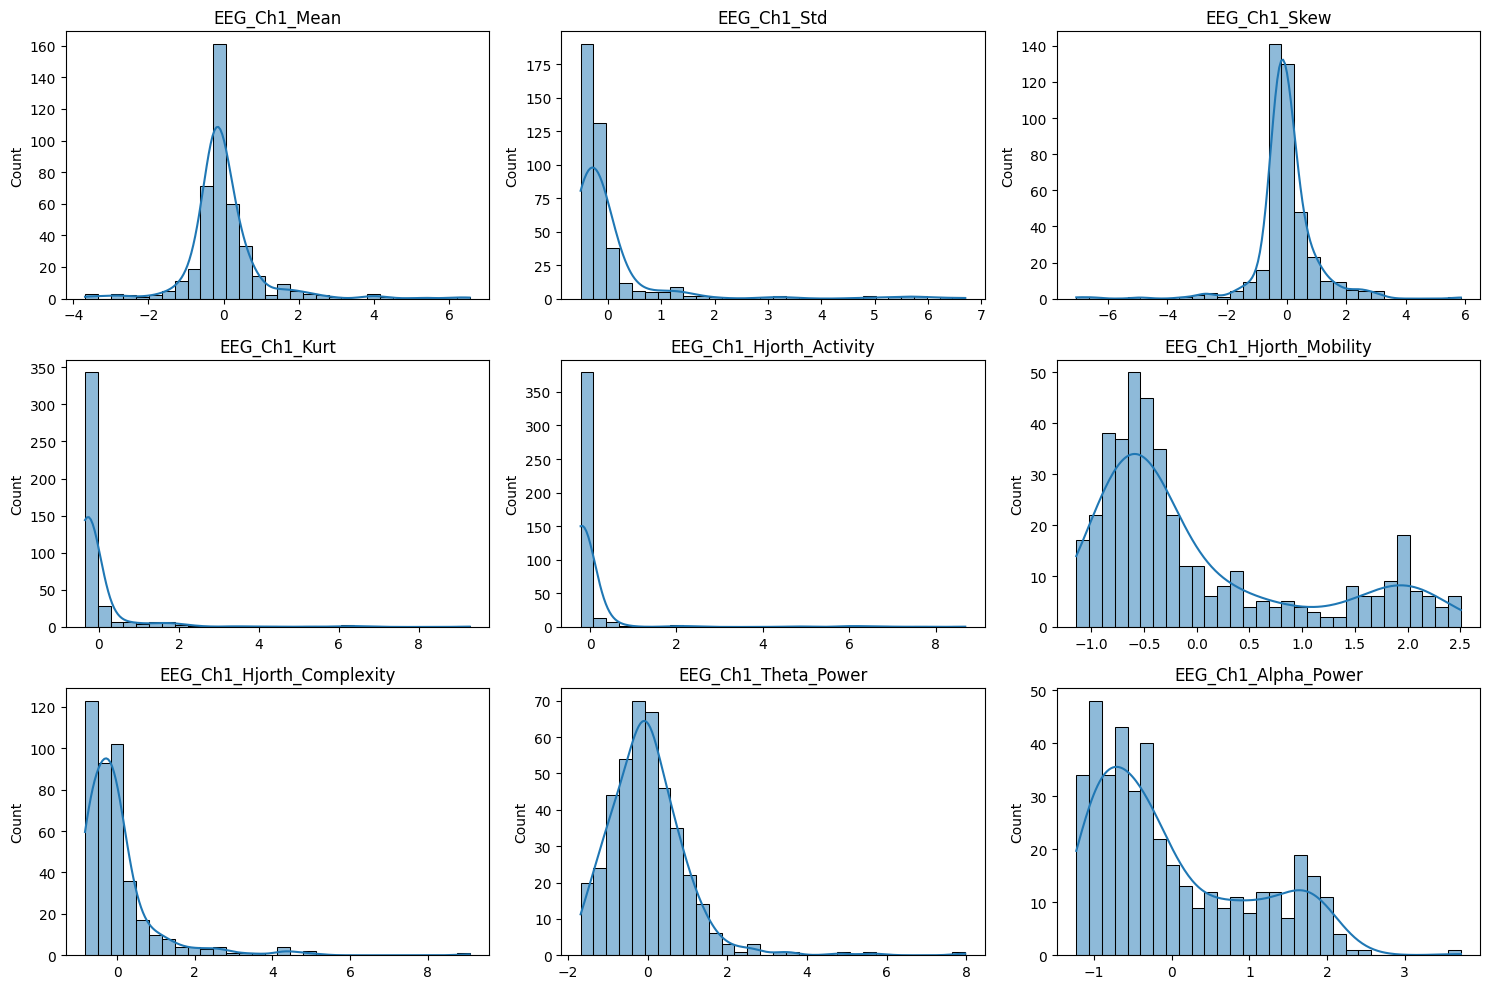


Calculating Feature Correlation Matrix (may take time)...
Correlation matrix shape: (170, 170)

Skipping heatmap visualization due to large number of features (>100).

Identifying Highly Correlated Feature Pairs (Threshold > 0.95)...

Found 18 Highly Correlated Feature Pairs (Threshold > 0.95). Examples:
ECG_Left_HRV_MeanNN      ECG_Right_HRV_MeanNN       0.999984
ECG_Left_HRV_pNN50       ECG_Right_HRV_pNN50        0.997343
ECG_Right_HRV_SDNN       ECG_Left_HRV_SDNN          0.994190
EEG_Ch4_Hjorth_Activity  EEG_Ch3_Hjorth_Activity    0.992966
ECG_Left_HRV_HF          ECG_Right_HRV_HF           0.989932
ECG_Left_HRV_RMSSD       ECG_Right_HRV_RMSSD        0.983087
ECG_Right_HRV_LFHF       ECG_Left_HRV_LFHF          0.982079
EEG_Ch1_Hjorth_Activity  EEG_Ch3_Hjorth_Activity    0.976361
ECG_Right_HRV_LF         ECG_Left_HRV_LF            0.972408
EEG_Ch4_Hjorth_Activity  EEG_Ch1_Hjorth_Activity    0.968416
dtype: float64


416

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

# --- Use the prepared variables ---
# X_explore_scaled, feature_names_explore are assumed available

# --- Convert to DataFrame ---
# Note: Creating a DataFrame from a large scaled array can consume memory.
# Perform analysis directly on numpy array where possible, or use a subset for DataFrame.
print("Creating DataFrame for exploration (might be memory intensive)...")
# Limit DataFrame size for initial exploration if too many features
max_cols_df = 500
if X_explore_scaled.shape[1] > max_cols_df:
    print(f" Using subset of features (first {max_cols_df}) for DataFrame exploration.")
    X_explore_df = pd.DataFrame(X_explore_scaled[:, :max_cols_df], columns=feature_names_explore[:max_cols_df])
else:
     X_explore_df = pd.DataFrame(X_explore_scaled, columns=feature_names_explore)


print("Feature DataFrame Head (DREAMER Fused Example - First 5):")
print(X_explore_df.iloc[:, :5].head())
print("\nBasic Statistics (First 5 Features):")
print(X_explore_df.iloc[:, :5].describe())

# --- Check for Zero Variance Features ---
var_thresh_explore = VarianceThreshold(threshold=0.01) # Check features with low variance after scaling
try:
    # Fit on the full scaled numpy array
    var_thresh_explore.fit(X_explore_scaled)
    low_variance_mask = ~var_thresh_explore.get_support()
    num_low_variance = np.sum(low_variance_mask)
    if num_low_variance > 0:
        low_variance_indices = np.where(low_variance_mask)[0]
        print(f"\nFeatures with low variance (threshold=0.01): {num_low_variance} features.")
        # Show examples using original feature names list
        print(f" Example Indices: {low_variance_indices[:10]}")
        print(f" Example Names: {[feature_names_explore[i] for i in low_variance_indices[:10]]}")
    else:
        print("\nNo features found with variance below threshold=0.01.")
except Exception as e:
    print(f"\nCould not perform variance threshold check: {e}")

# --- Visualize Feature Distributions (Example: First 9 features) ---
print("\nVisualizing Feature Distributions (First 9 Features)...")
plt.figure(figsize=(15, 10))
num_plot_features_explore = min(9, X_explore_scaled.shape[1])
for i in range(num_plot_features_explore):
    plt.subplot(3, 3, i + 1)
    feature_name_plot = feature_names_explore[i]
    # Use numpy array directly for plotting
    sns.histplot(X_explore_scaled[:, i], kde=True, bins=30)
    plt.title(feature_name_plot)
plt.tight_layout()
plt.show()

# --- Visualize Feature Correlations ---
# Calculating full correlation matrix can be very slow and memory-intensive.
# Consider calculating on a subset or skipping the heatmap plot.
print("\nCalculating Feature Correlation Matrix (may take time)...")
# Calculate on the DataFrame subset if created, otherwise calculate on numpy subset
correlation_matrix_explore = X_explore_df.corr() # Uses the DataFrame (potentially subset)
# If not using DataFrame:
# subset_corr_indices = np.random.choice(X_explore_scaled.shape[1], size=min(500, X_explore_scaled.shape[1]), replace=False)
# correlation_matrix_explore = np.corrcoef(X_explore_scaled[:, subset_corr_indices], rowvar=False)

print(f"Correlation matrix shape: {correlation_matrix_explore.shape}")

# Plot heatmap only if the matrix isn't excessively large
if correlation_matrix_explore.shape[0] <= 100: # Plot if 100 features or less
    print(f"\nVisualizing Feature Correlation Matrix...")
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix_explore, cmap='coolwarm', annot=False, xticklabels=False, yticklabels=False) # Hide labels if dense
    plt.title(f'Feature Correlation Matrix (DREAMER Fused - {correlation_matrix_explore.shape[0]} Features)')
    plt.show()
else:
    print("\nSkipping heatmap visualization due to large number of features (>100).")


# --- Identify Highly Correlated Pairs ---
threshold_explore = 0.95
print(f"\nIdentifying Highly Correlated Feature Pairs (Threshold > {threshold_explore})...")
# Use the calculated correlation matrix (potentially from the subset DataFrame)
if isinstance(correlation_matrix_explore, pd.DataFrame):
    highly_correlated_explore = correlation_matrix_explore.abs().unstack().sort_values(ascending=False).drop_duplicates()
    correlated_pairs_explore = highly_correlated_explore[(highly_correlated_explore > threshold_explore) & (highly_correlated_explore < 1.0)]
    if not correlated_pairs_explore.empty:
        print(f"\nFound {len(correlated_pairs_explore)} Highly Correlated Feature Pairs (Threshold > {threshold_explore}). Examples:")
        print(correlated_pairs_explore.head(10))
    else:
        print(f"\nNo feature pairs found with absolute correlation > {threshold_explore}.")
else:
    print(" Skipping detailed correlated pair analysis (requires DataFrame or more complex numpy handling).")


# Clean up
del X_explore_df, correlation_matrix_explore
# del highly_correlated_explore, correlated_pairs_explore # Might not exist
gc.collect()

## Class Balancing Considerations (DREAMER Stress Task)

Identified 170 feature columns for the stress task.

Filtering data for 'anger', 'fear', 'calmness' emotions...
Creating 'stress_bin' target variable (1 for anger/fear, 0 for calmness)...

Features for Stress Task (X_stress_full): (138, 170)
Labels for Stress Task (y_stress): (138,)
Groups for Stress Task (groups_stress): (138,)

Stress Task Class Distribution (0: Calm, 1: Stress):
Counter({np.int64(1): 92, np.int64(0): 46})


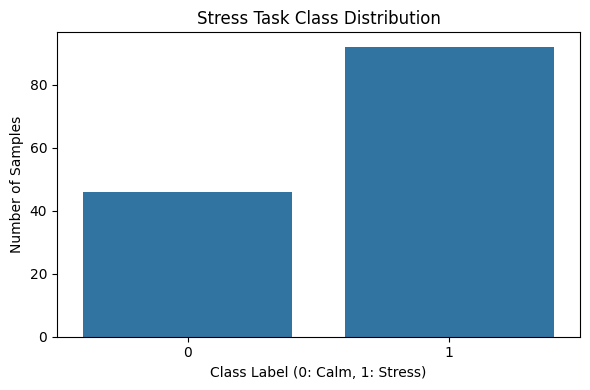

Imbalance Ratio: 2.00
Significant imbalance detected. Consider using class weights or within-fold balancing.

--- Balancing Strategy Note ---
Applying SMOTE or other over/under-sampling *before* GroupKFold is generally incorrect.
If balancing is needed, use techniques *within* the cross-validation loop.
This notebook will proceed *without* global balancing before the CV loop.

Applying StandardScaler to the selected stress task features...
Scaled Stress Features Shape: (138, 170)


In [10]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
# from imblearn.over_sampling import SMOTE # Import if you were to use it *inside* CV

# --- Define Feature Columns Consistently ---
# These are the columns representing the actual features in df_fixed_combined / df
# Exclude participant identifiers and target/metadata columns added later
if 'df' not in locals():
    raise NameError("DataFrame 'df' (created from df_fixed_combined) not found.")

# Get feature columns by excluding known non-feature columns
known_metadata_cols = ["participant", "video", "age", "gender", "video_name",
                       "target_emotion", "valence", "arousal", "dominance", "stress_bin"]
feature_columns_stress_task = [col for col in df.columns if col not in known_metadata_cols]

if not feature_columns_stress_task:
     raise ValueError("Could not identify feature columns in DataFrame 'df'.")
print(f"Identified {len(feature_columns_stress_task)} feature columns for the stress task.")

# --- Filter data and create the target variable ---
print("\nFiltering data for 'anger', 'fear', 'calmness' emotions...")
data_stress = df.loc[(df['target_emotion'] == 'anger') |
                     (df['target_emotion'] == 'fear') |
                     (df['target_emotion'] == 'calmness')].copy()

if data_stress.empty:
    raise ValueError("Filtered data ('data_stress') is empty. Check target emotions.")

print("Creating 'stress_bin' target variable (1 for anger/fear, 0 for calmness)...")
data_stress['stress_bin'] = data_stress['target_emotion'].map(
    {'anger': 1, 'fear': 1, 'calmness': 0}
)

# --- Define features, target, and groups using the identified columns ---
X_stress_full = data_stress[feature_columns_stress_task].values
y_stress = data_stress['stress_bin'].values
groups_stress = data_stress['participant'].values # Keep using 'participant' for groups

print(f"\nFeatures for Stress Task (X_stress_full): {X_stress_full.shape}")
print(f"Labels for Stress Task (y_stress): {y_stress.shape}")
print(f"Groups for Stress Task (groups_stress): {groups_stress.shape}")

# --- Check class distribution ---
print(f"\nStress Task Class Distribution (0: Calm, 1: Stress):")
stress_counts = Counter(y_stress)
print(stress_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_stress, order=sorted(stress_counts.keys()))
plt.title(f'Stress Task Class Distribution')
plt.xlabel('Class Label (0: Calm, 1: Stress)')
plt.ylabel('Number of Samples')
plt.xticks(ticks=sorted(stress_counts.keys()))
plt.tight_layout()
plt.show()

if len(stress_counts) >= 2: # Check if min function is applicable
    imbalance_ratio = max(stress_counts.values()) / min(stress_counts.values()) if min(stress_counts.values()) > 0 else float('inf')
    print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
    if imbalance_ratio > 1.5: # Example threshold
        print("Significant imbalance detected. Consider using class weights or within-fold balancing.")
    else:
        print("Classes are relatively balanced.")
else:
    print("Only one class present in the filtered data.")

# --- Balancing Note --- (Keep as before)
print("\n--- Balancing Strategy Note ---")
print("Applying SMOTE or other over/under-sampling *before* GroupKFold is generally incorrect.")
print("If balancing is needed, use techniques *within* the cross-validation loop.")
print("This notebook will proceed *without* global balancing before the CV loop.")

# --- Scaling the features for the Stress task ---
print("\nApplying StandardScaler to the selected stress task features...")
scaler_stress = StandardScaler()
# Handle potential NaNs introduced if original feature extraction failed for some samples
from sklearn.impute import SimpleImputer
imputer_stress = SimpleImputer(strategy='mean') # Or 'median', 'constant' etc.
X_stress_imputed = imputer_stress.fit_transform(X_stress_full)
X_stress_scaled = scaler_stress.fit_transform(X_stress_imputed)
print(f"Scaled Stress Features Shape: {X_stress_scaled.shape}")

## Feature Selection Strategies (DREAMER Fused EEG+ECG for Stress Task)

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Ensure y_stress and groups_stress are available from the previous cell

# --- Use the prepared variables for the stress task ---
# X_stress_scaled, y_stress are assumed available
# feature_columns_stress_task contains the names corresponding to X_stress_scaled columns
if 'X_stress_scaled' not in locals() or 'y_stress' not in locals() or 'feature_columns_stress_task' not in locals():
     raise NameError("Required variables (X_stress_scaled, y_stress, feature_columns_stress_task) not found.")

X_train_for_select_stress = X_stress_scaled
y_train_for_select_stress = y_stress
feature_names_stress = feature_columns_stress_task # Use the names identified in the previous cell

# --- Strategy 1: Filter Method (SelectKBest using ANOVA F-value) ---
k_best_features_stress = 100
print(f"\n--- Applying SelectKBest (k={k_best_features_stress}) ---")

if k_best_features_stress <= 0 or k_best_features_stress >= X_train_for_select_stress.shape[1]:
    print(f"Warning: k={k_best_features_stress} is invalid. Skipping SelectKBest.")
    X_stress_kbest = X_train_for_select_stress
    selected_kbest_indices_stress = np.arange(X_train_for_select_stress.shape[1])
else:
    try:
        selector_kbest_stress = SelectKBest(score_func=f_classif, k=k_best_features_stress)
        selector_kbest_stress.fit(X_train_for_select_stress, y_train_for_select_stress)
        selected_kbest_indices_stress = selector_kbest_stress.get_support(indices=True)
        # Get names using the correct list
        selected_feature_names_kbest_stress = [feature_names_stress[i] for i in selected_kbest_indices_stress]
        print(f"Selected top {k_best_features_stress} features using SelectKBest. Example Names: {selected_feature_names_kbest_stress[:10]}")
        X_stress_kbest = X_train_for_select_stress[:, selected_kbest_indices_stress]
        print(f"Shape after SelectKBest selection: {X_stress_kbest.shape}")
    except Exception as e:
        print(f"Error during SelectKBest: {e}. Skipping.")
        X_stress_kbest = X_train_for_select_stress
        selected_kbest_indices_stress = np.arange(X_train_for_select_stress.shape[1])


# --- Strategy 2: Embedded Method (Random Forest Feature Importance) ---
print("\n--- Using Embedded Method (Random Forest Feature Importance) ---")
print("Training RandomForestClassifier for feature importances...")
rf_for_importance_stress = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
try:
    rf_for_importance_stress.fit(X_train_for_select_stress, y_train_for_select_stress)
    importances_stress = rf_for_importance_stress.feature_importances_
    model_to_use_importance_stress = rf_for_importance_stress
    indices_stress = np.argsort(importances_stress)[::-1]
    print(f"\nTop 10 Features (Random Forest Importance):")
    for f in range(min(10, X_train_for_select_stress.shape[1])):
         # Use correct feature names list
        print(f"{f + 1}. Feature {feature_names_stress[indices_stress[f]]} ({importances_stress[indices_stress[f]]:.4f})")

    # --- Use SelectFromModel ---
    print("\nApplying SelectFromModel based on RF importance...")
    selector_sfm_stress = SelectFromModel(estimator=model_to_use_importance_stress, threshold='median', prefit=True)
    X_stress_sfm = selector_sfm_stress.transform(X_train_for_select_stress)
    selected_sfm_indices_stress = selector_sfm_stress.get_support(indices=True)
     # Use correct feature names list
    selected_sfm_names_stress = [feature_names_stress[i] for i in selected_sfm_indices_stress]
    print(f"Selected {len(selected_sfm_names_stress)} features using SelectFromModel (median threshold). Example: {selected_sfm_names_stress[:10]}")
    print(f"Shape after SelectFromModel selection: {X_stress_sfm.shape}")
except Exception as e:
    print(f"Error during RF Importance/SelectFromModel: {e}")
    X_stress_sfm = X_train_for_select_stress
    selected_sfm_indices_stress = np.arange(X_train_for_select_stress.shape[1])

# --- Strategy 3: Wrapper Method (Recursive Feature Elimination - RFE) ---
# RFE is computationally expensive. Use cautiously or on a subset.
# Skipping RFE in this example due to potential long runtime on many features.
# If you want to run it:
# n_features_to_select_rfe_stress = 50
# estimator_rfe_stress = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced')
# selector_rfe_stress = RFE(estimator=estimator_rfe_stress, n_features_to_select=n_features_to_select_rfe_stress, step=0.1) # Remove 10% each step
# print(f"\nFitting RFE selector (Targeting {n_features_to_select_rfe_stress} features, this will take a long time)...")
# selector_rfe_stress.fit(X_train_for_select_stress, y_train_for_select_stress)
# X_stress_rfe = selector_rfe_stress.transform(X_train_for_select_stress)
# selected_rfe_indices_stress = selector_rfe_stress.get_support(indices=True)
# print(f"Shape after RFE selection: {X_stress_rfe.shape}")
X_stress_rfe = None # Placeholder if skipped
print("\nSkipping RFE due to potential long runtime.")


# --- Conclusion ---
print("\n--- Feature Selection Options Prepared (DREAMER Fused Stress Task) ---")
print("You can now choose which feature set to use in the GroupKFold CV loop below:")
print(f" 1. Full Scaled Features: X_stress_scaled ({X_stress_scaled.shape})")
print(f" 2. SelectKBest Features: X_stress_kbest ({X_stress_kbest.shape if X_stress_kbest is not None else 'N/A'})")
print(f" 3. SelectFromModel (RF): X_stress_sfm ({X_stress_sfm.shape if X_stress_sfm is not None else 'N/A'})")
print(f" 4. RFE Features: X_stress_rfe ({X_stress_rfe.shape if X_stress_rfe is not None else 'Skipped'})")
print(f" 5. Original Arbitrary Slice: data.iloc[:, 0:100].values (Used previously)")
print("\nRecommendation: Modify the next cell to use one of options 1-4 instead of option 5.")


--- Applying SelectKBest (k=100) ---
Selected top 100 features using SelectKBest. Example Names: ['EEG_Ch1_Mean', 'EEG_Ch1_Hjorth_Mobility', 'EEG_Ch1_Hjorth_Complexity', 'EEG_Ch1_Beta_Power', 'EEG_Ch2_Mean', 'EEG_Ch2_Std', 'EEG_Ch2_Skew', 'EEG_Ch2_Kurt', 'EEG_Ch2_Hjorth_Mobility', 'EEG_Ch2_Hjorth_Complexity']
Shape after SelectKBest selection: (138, 100)

--- Using Embedded Method (Random Forest Feature Importance) ---
Training RandomForestClassifier for feature importances...

Top 10 Features (Random Forest Importance):
1. Feature ECG_Left_HRV_LF (0.0291)
2. Feature EEG_Ch11_Mean (0.0247)
3. Feature EEG_Ch2_Mean (0.0232)
4. Feature EEG_Ch14_Mean (0.0190)
5. Feature EEG_Ch12_Hjorth_Complexity (0.0189)
6. Feature ECG_Left_HRV_HF (0.0182)
7. Feature EEG_Ch2_Kurt (0.0181)
8. Feature ECG_Right_HRV_pNN50 (0.0152)
9. Feature EEG_Ch12_Hjorth_Activity (0.0136)
10. Feature EEG_Ch10_Mean (0.0133)

Applying SelectFromModel based on RF importance...
Selected 85 features using SelectFromModel (med

## Final ML Model Training & Evaluation on Selected Fixed Features

In [12]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline # Use Pipeline for clearer steps
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score # Alternative CV approach

# Import classifiers again for clarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import time
import pandas as pd
import numpy as np

# --- 1. Define X, y, groups ---
# Choose ONE of the feature sets prepared earlier.
# Recommendation: Start with the full scaled set or SelectKBest/SelectFromModel.

# Option 1: Use all scaled features
if 'X_stress_scaled' in locals():
    X = X_stress_scaled
    print(f"Using ALL scaled fused features for ML. Shape: {X.shape}")
elif 'X_stress_full' in locals(): # Fallback if scaling failed but imputation worked
     print("Warning: Scaled features not found, using imputed-only features.")
     X = X_stress_imputed # Requires SimpleImputer defined previously
else:
     raise NameError("Neither X_stress_scaled nor X_stress_full found.")

# # Option 2: Use SelectKBest features
# if 'X_stress_kbest' in locals() and X_stress_kbest is not None:
#     X = X_stress_kbest
#     print(f"Using SelectKBest features for ML. Shape: {X.shape}")
# else:
#     raise NameError("X_stress_kbest not defined or is None. Cannot use SelectKBest features.")

# # Option 3: Use SelectFromModel features
# if 'X_stress_sfm' in locals() and X_stress_sfm is not None:
#     X = X_stress_sfm
#     print(f"Using SelectFromModel features for ML. Shape: {X.shape}")
# else:
#     raise NameError("X_stress_sfm not defined or is None. Cannot use SelectFromModel features.")


# Use the corresponding y and groups defined in the "Class Balancing Considerations" cell
if 'y_stress' not in locals() or 'groups_stress' not in locals():
     raise NameError("Target 'y_stress' or 'groups_stress' not found.")
y = y_stress
groups = groups_stress

# --- 2. Corrected Cross-Validation Function ---
# Defines the CV logic properly scoring on each fold's test set.
def run_cv_fixed(pipeline, X, y, groups, n_splits=10):
    gkf = GroupKFold(n_splits=n_splits)
    scores = []
    balanced_scores = []
    fit_times = []
    score_times = []

    print(f"Running {n_splits}-Fold Group Cross-Validation...")
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        start_fit = time.time()
        pipeline.fit(X_train, y_train)
        fit_times.append(time.time() - start_fit)

        start_score = time.time()
        y_pred = pipeline.predict(X_test)
        score_times.append(time.time() - start_score)

        scores.append(accuracy_score(y_test, y_pred))
        balanced_scores.append(balanced_accuracy_score(y_test, y_pred))
        # print(f" Fold {fold+1}: Acc={scores[-1]:.4f}, BalAcc={balanced_scores[-1]:.4f}") # Optional: print fold scores

    print("CV Complete.")
    return scores, balanced_scores, fit_times, score_times


# --- 3. Define Classifiers ---
# Using balanced weights where appropriate based on previous analysis
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process", # GP is often too slow
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, class_weight='balanced', random_state=42),
    SVC(gamma=2, C=1, class_weight='balanced', random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42), # Often slow
    DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight='balanced', random_state=42, n_jobs=-1),
    AdaBoostClassifier(random_state=42), # AdaBoost doesn't have class_weight, might struggle with imbalance
    GaussianNB()
]

# --- 4. Run Cross-Validation Loop ---
results_fixed_feat = []

print("\nStarting Cross-Validation for all classifiers...")
for name, classifier in zip(names, classifiers):
    print(f"\nProcessing: {name}")
    # Create a minimal pipeline: Impute (robustness) -> Classifier
    # Scaling is already done *before* this CV loop if using X_stress_scaled etc.
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), # Handle any potential leftover NaNs
        ('classification', classifier)
    ])

    try:
        # Run the corrected CV function
        scores, bal_scores, fit_times, score_times = run_cv_fixed(pipeline, X, y, groups, n_splits=10)

        results_fixed_feat.append([
            name,
            np.mean(scores),
            np.std(scores),
            np.mean(bal_scores),
            np.std(bal_scores),
            np.mean(fit_times),
            np.mean(score_times)
        ])
        print(f" {name}: Mean Accuracy={np.mean(scores):.4f} (+/- {np.std(scores):.4f}), Mean Balanced Accuracy={np.mean(bal_scores):.4f} (+/- {np.std(bal_scores):.4f})")

    except Exception as e:
        print(f"!!! Error during CV for {name}: {e} !!!")
        results_fixed_feat.append([name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])


# --- 5. Display Results ---
print("\n--- Final Cross-Validation Results (Fixed Features) ---")
results_df_fixed = pd.DataFrame(
    results_fixed_feat,
    columns=['Classifier', 'Mean Accuracy', 'Std Dev Accuracy', 'Mean Balanced Acc', 'Std Dev Balanced Acc', 'Mean Fit Time (s)', 'Mean Score Time (s)']
).sort_values(by='Mean Balanced Acc', ascending=False)

print(results_df_fixed)

# Optionally save results
# results_df_fixed.to_csv('results_fixed_features.csv', index=False)

Using ALL scaled fused features for ML. Shape: (138, 170)

Starting Cross-Validation for all classifiers...

Processing: Nearest Neighbors
Running 10-Fold Group Cross-Validation...
CV Complete.
 Nearest Neighbors: Mean Accuracy=0.7056 (+/- 0.0844), Mean Balanced Accuracy=0.6208 (+/- 0.0773)

Processing: Linear SVM
Running 10-Fold Group Cross-Validation...
CV Complete.
 Linear SVM: Mean Accuracy=0.7000 (+/- 0.1096), Mean Balanced Accuracy=0.6750 (+/- 0.1275)

Processing: RBF SVM
Running 10-Fold Group Cross-Validation...
CV Complete.
 RBF SVM: Mean Accuracy=0.6667 (+/- 0.0000), Mean Balanced Accuracy=0.5000 (+/- 0.0000)

Processing: Decision Tree
Running 10-Fold Group Cross-Validation...
CV Complete.
 Decision Tree: Mean Accuracy=0.6917 (+/- 0.1317), Mean Balanced Accuracy=0.6708 (+/- 0.1249)

Processing: Random Forest
Running 10-Fold Group Cross-Validation...
CV Complete.
 Random Forest: Mean Accuracy=0.6167 (+/- 0.1030), Mean Balanced Accuracy=0.5354 (+/- 0.1243)

Processing: AdaBoost
